### $\color{indianred}{\text{ДОДАТНА ВЈЕЖБА ИЗ АСТРОСТАТИСТИКЕ (v2)}} $

### *Physics-Informed Neural Network* (PINN)

У вјежби су ријешени проблеми симулације и инверзије везано за пригушени хармонијски осцилатор.

**БИЋЕ ДОДАТИ КОМЕНТАРИ У КОДУ, ТЕ МАТЕМАТИЧКИ ОПИС СВЕГА ШТО СЕ ДЕШАВА!**

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

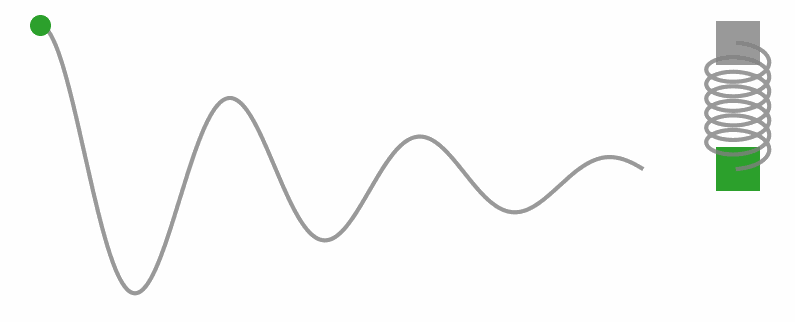

### **СИМУЛАЦИЈА**

In [2]:
def exact_solution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

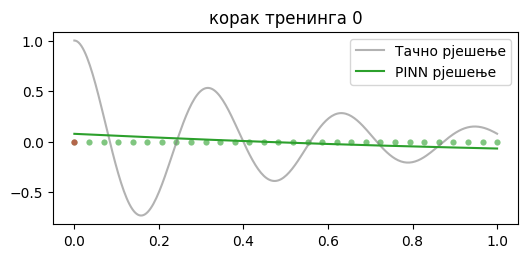

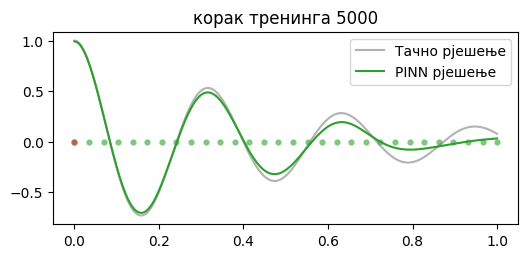

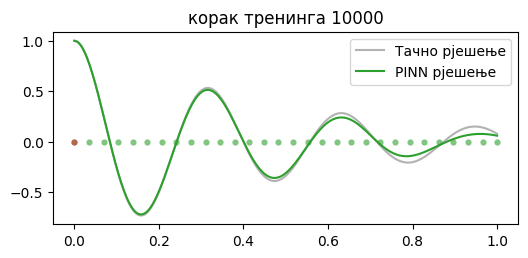

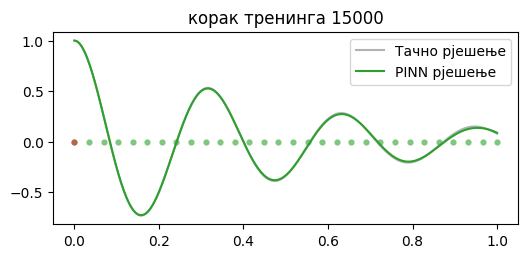

In [6]:
torch.manual_seed(123)

pinn = FCN(1,1,32,3)

t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)# (1, 1)
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# (30, 1)

d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()

    lambda1, lambda2 = 1e-1, 1e-4
    
    u = pinn(t_boundary)# (1, 1)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]# (1, 1)
    loss2 = (torch.squeeze(dudt) - 0)**2

    u = pinn(t_physics)# (30, 1)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]# (30, 1)
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]# (30, 1)
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()

    if i % 5000 == 0: 
       
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Тачно рјешење", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN рјешење", color="tab:green")
        plt.title(f"корак тренинга {i}")
        plt.legend()
        plt.show()

### **ИНВЕРЗИЈА**

Права вриједност mu : 4


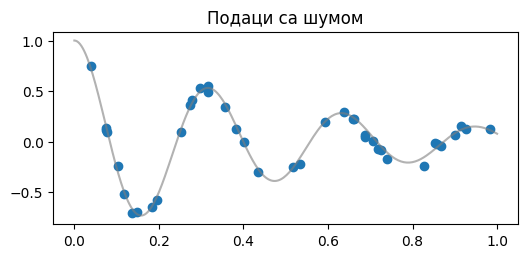

In [10]:
torch.manual_seed(123)
d, w0 = 2, 20
print(f"Права вриједност mu : {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

plt.figure(figsize=(6,2.5))
plt.title("Подаци са шумом")
plt.scatter(t_obs[:,0], u_obs[:,0])
plt.plot(t_test[:,0], u_exact[:,0], label="Тачно рјешење", color="tab:grey", alpha=0.6)
plt.show()

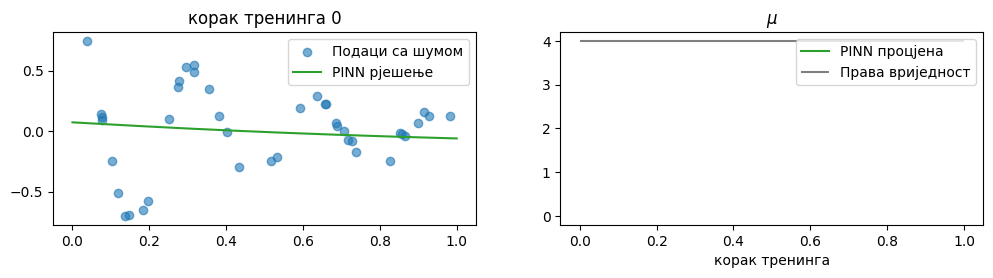

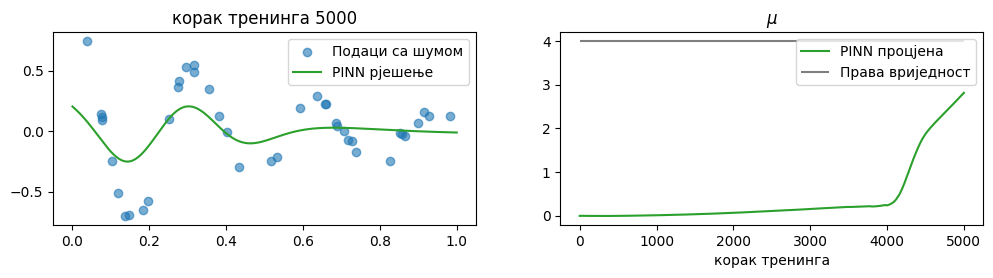

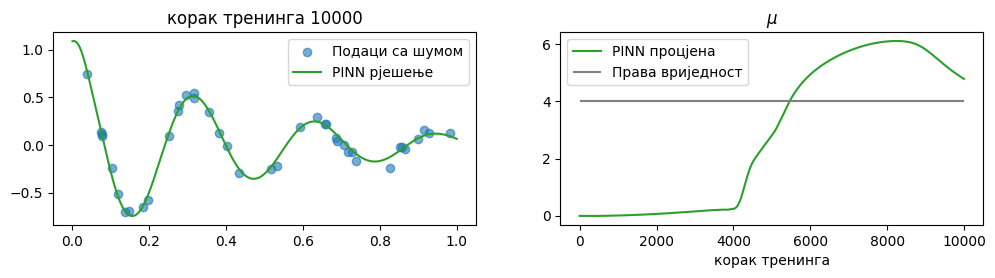

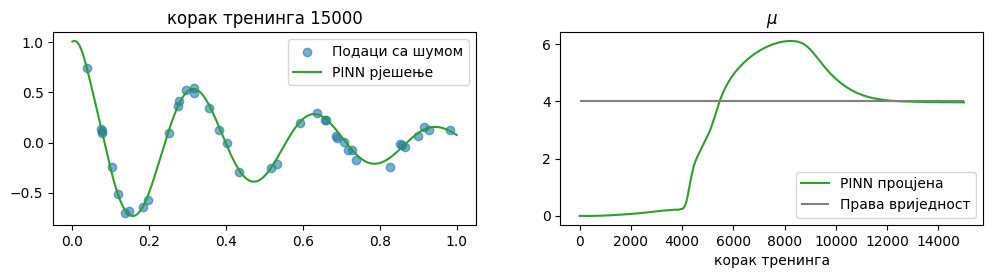

In [11]:
torch.manual_seed(123)

pinn = FCN(1,1,32,3)

t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# (30, 1)

d, w0 = 2, 20
_, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
mus = []
for i in range(15001):
    optimiser.zero_grad()
    lambda1 = 1e4
    u = pinn(t_physics)# (30, 1)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]# (30, 1)
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]# (30, 1)
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)

    loss = loss1 + lambda1*loss2
    loss.backward()
    optimiser.step()

    mus.append(mu.item())

    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(12,2.5))
        
        plt.subplot(1,2,1)
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Подаци са шумом", alpha=0.6, color="tab:blue")
        plt.plot(t_test[:,0], u[:,0], label="PINN рјешење", color="tab:green")
        plt.title(f"корак тренинга {i}")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.title("$\mu$")
        plt.plot(mus, label="PINN процјена", color="tab:green")
        plt.hlines(2*d, 0, len(mus), label="Права вриједност", color="tab:grey")
        plt.xlabel("корак тренинга")
        plt.legend()
        
        plt.show()
